In [1]:
import numpy as np
import pandas as pd
import urllib.request as requests
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [2]:
data = pd.read_csv('dataset.csv')
data

,sentiment,comment
0,5,Chất lượng sản phẩm:tốt Đúng với mô tả:đẹp Hà...
1,5,Với giá thành này thì hàng khá ổn . Bị lỗi pin...
2,5,Tính năng nổi bật:máy sáng Đúng với mô tả:chuẩ...
3,4,"Máy đã thay vỏ nên ngoại hình đẹp, dùng làm má..."
4,5,Chất lượng sản phẩm:sản phẩm dùng ổn định Máy...
...,...,...
2519,1,Chx nhận đc hàng
2520,3,Đặt pin xanh giao pin màu xám
2521,2,Shop ghi pin mới 100% nhưng không phải đây là ...
2522,5,Rất tốt


Text(0.5, 1.0, 'Count of reviews by starts')

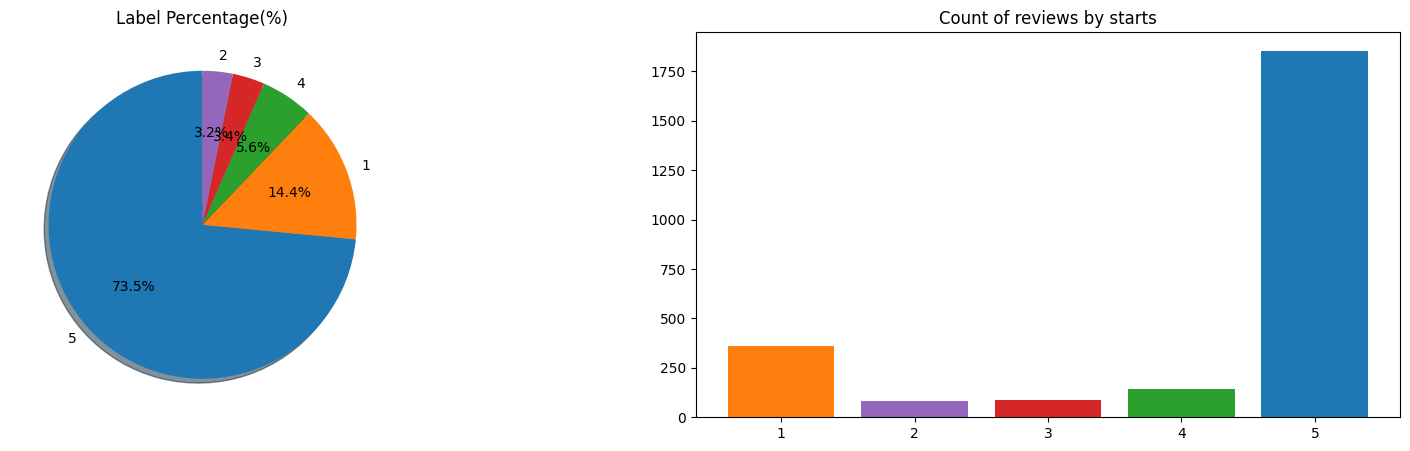

In [3]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(20,5))

labels = data['sentiment'].value_counts().keys()
sizes = data['sentiment'].value_counts()

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Label Percentage(%)')
axes[1].bar(labels, sizes, color=sns.color_palette())
axes[1].set_title('Count of reviews by starts')

Pre Processing

In [4]:
stop_words = []
with open('vietnamese-stopwords.txt', encoding='utf-8') as f:
    stop_words = [t for t in f.read().split('\n')]

In [5]:

sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smile_emoji        = r"[8:=;]['`\-]?[)d]+"
sad_emoji          = r"[8:=;]['`\-]?\(+"
neutral_emoji      = r"[8:=;]['`\-]?[\/|l*]"
lol_emoji          = r"[8:=;]['`\-]?p+"

def preprocess(input:str):
    # Lower
    input = input.lower()
    # clean
    input = input.strip().replace('\n', '')

    # Replace 3 or more consecutive letters by 2 letter.
    input = re.sub(sequencePattern, seqReplacePattern, input)
    
    # Replace all emojis.
    input = re.sub(r'<3', 'tim', input)
    input = re.sub(smile_emoji, 'cười', input)
    input = re.sub(sad_emoji, 'buồn', input)
    input = re.sub(neutral_emoji, 'bình thường', input)
    input = re.sub(lol_emoji, 'vui', input)
    
    # Keep word
    input = re.sub('\[.*?\]', ' ', input)
    input = re.sub('https?://\S+|www\.\S+', ' ', input)
    input = re.sub('<.*?>+', ' ', input)
    input = re.sub('[%s]' % re.escape(string.punctuation), ' ', input)
    input = re.sub('\n', ' ', input)
    input = re.sub('\w*\d\w*', ' ', input)
    
    return ' '.join([word for word in input.split() if word not in stop_words])

data.dropna()
data["processed"] = data["comment"].apply(lambda x: preprocess(x))
data.head(10)

def scale(x:int):
    if x == 5:
        return 1
    return 0
data["sentiment"] = data["sentiment"].apply(lambda x: scale(x))

Text(0.5, 1.0, 'Mean of reviews after processed: 11')

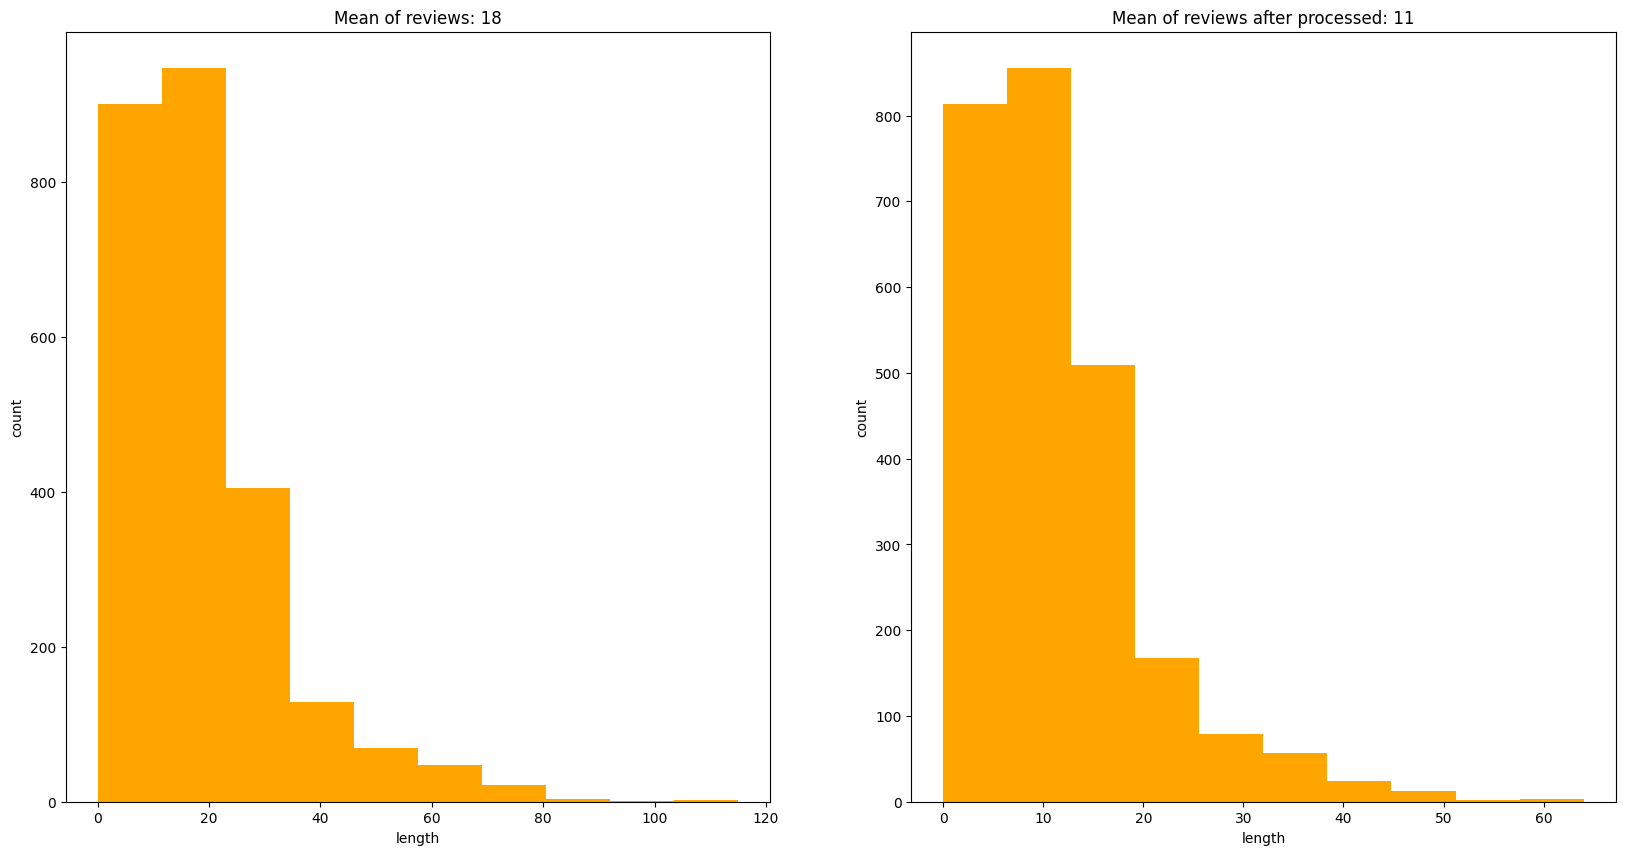

In [6]:
# Histogram
comment_len = [len(x.split()) for x in data['comment']]
processed_len = [len(x.split()) for x in data['processed']]

fig, axes = plt.subplots(1,2, figsize=(20, 10))
axes[0].hist(x=comment_len, color="orange")
axes[0].set_xlabel('length')
axes[0].set_ylabel('count')
axes[0].set_title(f'Mean of reviews: {np.mean(comment_len, dtype=np.int32)}')

axes[1].hist(x=processed_len, color="orange")
axes[1].set_xlabel('length')
axes[1].set_ylabel('count')
axes[1].set_title(f'Mean of reviews after processed: {np.mean(processed_len, dtype=np.int32)}')

In [7]:
# word cloud
def get_word_cloud(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    word_cloud = WordCloud(background_color=color, width=2500, height=2000).generate(cleaned_word)
    return word_cloud
comment_word_cloud = get_word_cloud(data['comment'])
processed_word_cloud = get_word_cloud(data['processed'])

Text(0.5, 1.0, 'Word cloud of reviews after processed')

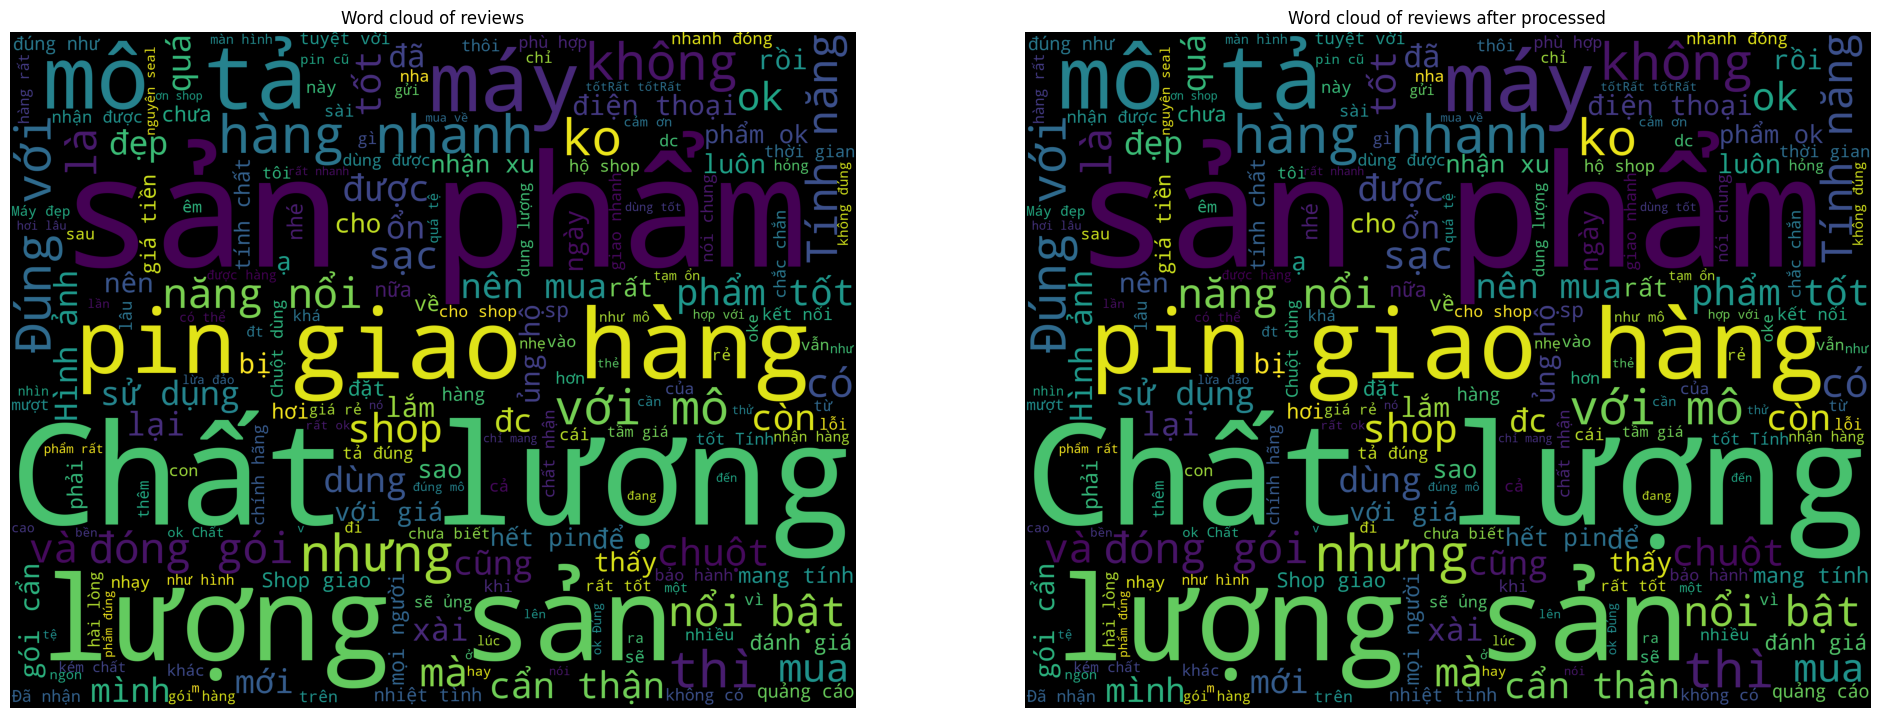

In [8]:
fig, axes = plt.subplots(1,2, figsize=(24, 16))
axes[0].imshow(comment_word_cloud)
axes[0].axis('off')
axes[0].set_title('Word cloud of reviews')

axes[1].imshow(comment_word_cloud)
axes[1].axis('off')
axes[1].set_title('Word cloud of reviews after processed')

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Bidirectional, SimpleRNN
from sklearn.model_selection import train_test_split


In [10]:
vocab_size = 10000
embedding_dim = 64
max_length = 20

sequences = data.processed
labels = data.sentiment

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sequences)

In [11]:
X_train, X_test, train_labels, test_labels = train_test_split(sequences, labels, test_size = 0.2, random_state = 42)


In [12]:
train_sequences = tokenizer.texts_to_sequences(X_train)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating='post', padding='post')
padded_train_sequences

array([[  87,  122,    0, ...,    0,    0,    0],
       [  14,   10,  123, ...,  662,  761,   38],
       [   6,    2,    3, ..., 2271,   10,    0],
       ...,
       [  25,   27,   28, ...,   35,    0,    0],
       [  17,   43,  132, ...,    0,    0,    0],
       [   6,    2,  128, ...,    0,    0,    0]])

In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating='post', padding='post')
padded_test_sequences.shape

(505, 20)

Model

In [14]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(SimpleRNN(32))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model1.fit(padded_train_sequences, train_labels, epochs=10, validation_data=(padded_test_sequences, test_labels))

Epoch 1/10
64/64 [==============================] - 2s 11ms/step - loss: 0.5015 - accuracy: 0.7712 - val_loss: 0.4582 - val_accuracy: 0.8000
Epoch 2/10
64/64 [==============================] - 0s 8ms/step - loss: 0.3659 - accuracy: 0.8504 - val_loss: 0.4530 - val_accuracy: 0.8079
Epoch 3/10
64/64 [==============================] - 0s 7ms/step - loss: 0.2658 - accuracy: 0.9014 - val_loss: 0.5093 - val_accuracy: 0.7861
Epoch 4/10
64/64 [==============================] - 0s 7ms/step - loss: 0.2006 - accuracy: 0.9282 - val_loss: 0.4679 - val_accuracy: 0.8020
Epoch 5/10
64/64 [==============================] - 0s 7ms/step - loss: 0.1310 - accuracy: 0.9594 - val_loss: 0.5165 - val_accuracy: 0.8119
Epoch 6/10
64/64 [==============================] - 1s 8ms/step - loss: 0.1104 - accuracy: 0.9604 - val_loss: 0.4901 - val_accuracy: 0.8198
Epoch 7/10
64/64 [==============================] - 1s 8ms/step - loss: 0.0962 - accuracy: 0.9663 - val_loss: 0.5177 - val_accuracy: 0.8119
Epoch 8/10
64/64 [=

In [15]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(padded_train_sequences, train_labels, epochs=10, validation_data=(padded_test_sequences, test_labels))

Epoch 1/10
64/64 [==============================] - 4s 23ms/step - loss: 0.5750 - accuracy: 0.7306 - val_loss: 0.4782 - val_accuracy: 0.7327
Epoch 2/10
64/64 [==============================] - 1s 11ms/step - loss: 0.4010 - accuracy: 0.8123 - val_loss: 0.4065 - val_accuracy: 0.8297
Epoch 3/10
64/64 [==============================] - 1s 13ms/step - loss: 0.3051 - accuracy: 0.8762 - val_loss: 0.4092 - val_accuracy: 0.8218
Epoch 4/10
64/64 [==============================] - 1s 11ms/step - loss: 0.2538 - accuracy: 0.8985 - val_loss: 0.4648 - val_accuracy: 0.8020
Epoch 5/10
64/64 [==============================] - 1s 12ms/step - loss: 0.2161 - accuracy: 0.9203 - val_loss: 0.5144 - val_accuracy: 0.8099
Epoch 6/10
53/64 [=======================>......] - ETA: 0s - loss: 0.1899 - accuracy: 0.9245

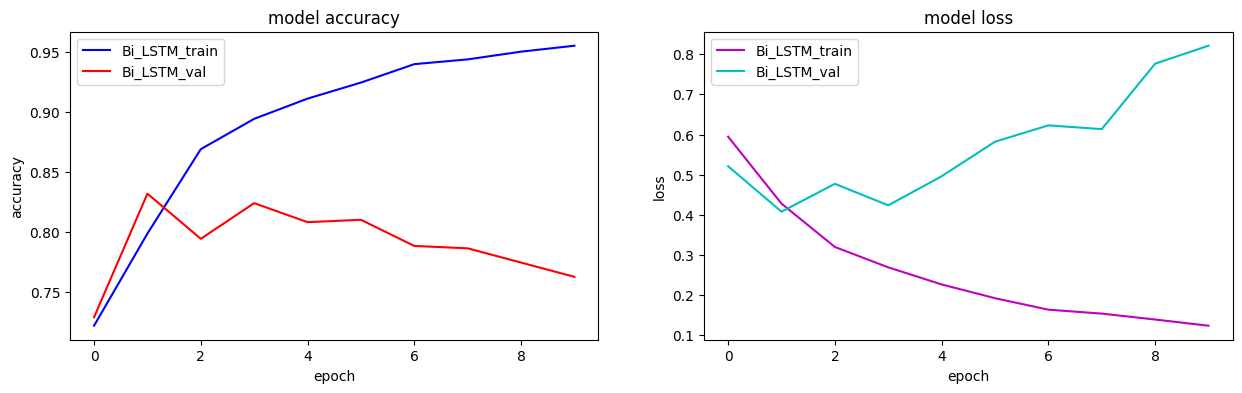

In [ ]:
s, (at, al) = plt.subplots(1, 2, figsize=(15,4))
at.plot(history2.history['accuracy'], c= 'b', label='Bi_LSTM_train')
at.plot(history2.history['val_accuracy'], c='r', label='Bi_LSTM_val')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend()

al.plot(history2.history['loss'], c='m', label='Bi_LSTM_train')
al.plot(history2.history['val_loss'], c='c', label='Bi_LSTM_val')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend()

In [ ]:
def my_predict(input:list):
    input = [preprocess(i) for i in input]
    text_tokenizer = tokenizer.texts_to_sequences(pd.Series(input))
    padded_test = pad_sequences(text_tokenizer, maxlen=max_length, truncating='post', padding='post')
    y_predict = model2.predict(padded_test)
    for t, pred in zip(input, y_predict):
        print(f'{t} : {sentiment(pred)} ({pred.round(decimals=3)})')

def sentiment(x:int):
    if x > 0.6:
        return 'positive'
    if x > 0.4:
        return 'neutral'
    return 'negative'


texts = ['sản phẩm tốt', 'ổn', 'k ổn', 'tệ', 'giao sai hàng', 'điện thoại xài tạm được', 'ok <3', 'áo bị bung chỉ']
y_predict = my_predict(texts)
#y_predict = my_predict(texts)

1/1 [==============================] - 1s 625ms/step
sản phẩm tốt : positive ([0.952])
ổn : negative ([0.393])
k ổn : negative ([0.315])
tệ : negative ([0.094])
giao sai hàng : negative ([0.092])
điện thoại xài tạm : positive ([0.829])
ok tim : positive ([0.969])
áo bung : negative ([0.176])


In [ ]:
test = X_test.to_list()[:10]
y_predict = my_predict(test)

1/1 [==============================] - 0s 19ms/step
pin ko sd dc dung nội trở hàng sd 🥲 : negative ([0.196])
eoai ơaa okk laoa qpaa sekj foe clxx mzz aiue aoqq paio m : positive ([0.992])
khá ok : positive ([0.948])
nhân viên tốt : positive ([0.623])
sai cai dat moi tro choi ko dc f z va shope cung ko cai dc va nut giua bi liet nhung may co may tram dung nhac cung dc 👍 : positive ([0.994])
chất sản phẩm tốt năng nổi bật hơi chai pin đổi ok mô tả tuyệt vời : positive ([0.999])
phẩm tốt : positive ([0.941])
máy máy lỗi : negative ([0.136])
chất sản phẩm tuyệt vời đóng gói sản phẩm chắn : positive ([1.])
mô tả chuẩn chất sản phẩm tốt năng nổi bật đẹp giao hàng đóng gói đẹp chắn nhân viên giao hàng nhiệt tình vui vẻ : positive ([1.])
